Using device: cuda:0


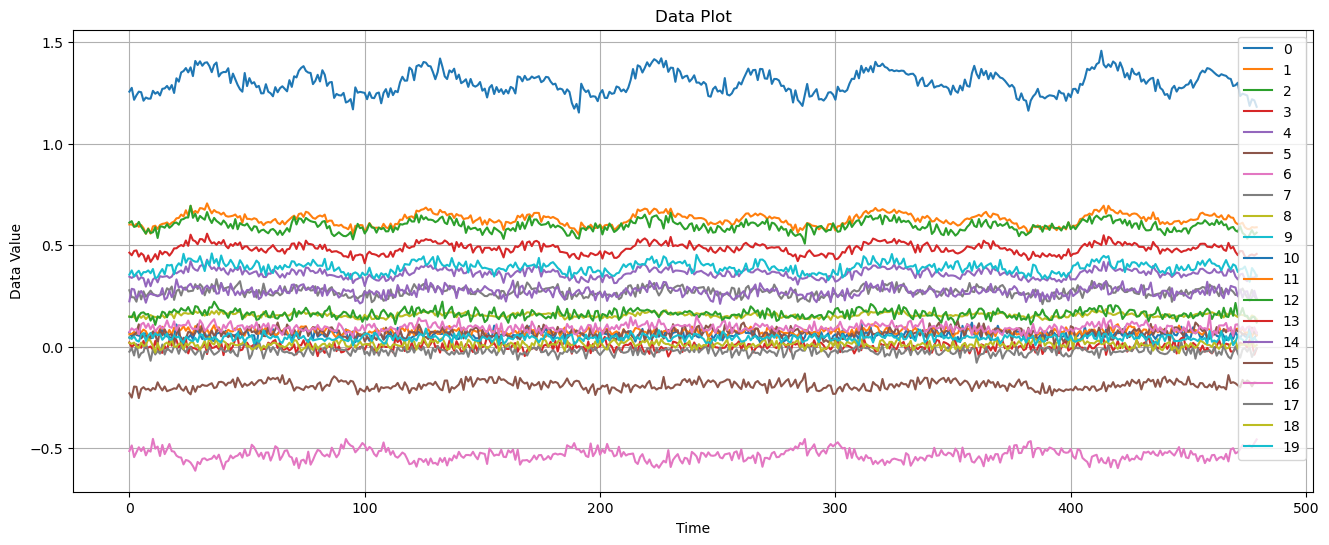

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

def read_excel_power(file_path= ""):
    pfData = pd.read_excel(file_path, engine='openpyxl', sheet_name=0, parse_dates=['Timestamp'])
    phaseData = pd.read_excel(file_path, engine='openpyxl', sheet_name=1, parse_dates=['Timestamp'])
    pfData.set_index('Timestamp', inplace=True)
    phaseData.set_index('Timestamp', inplace=True)
    return pfData, phaseData
attackPfData, attackPhaseData= read_excel_power("first round/attack_all.xlsx")
attackPfData2, attackPhaseData2= read_excel_power("fdia_data.xlsx")
basePfData, basePhaseData= read_excel_power("first round/base_all.xlsx")
attackPfData= attackPfData.to_numpy()
attackPhaseData= attackPhaseData.to_numpy()
attackPfData2= attackPfData2.to_numpy()
attackPhaseData2= attackPhaseData2.to_numpy()
basePfData= basePfData.to_numpy()
basePhaseData= basePhaseData.to_numpy()
data= basePfData

plt.figure(figsize=(16, 6))
for i in range(data.shape[1]):
    #plt.plot(data.index, data[i], label=i)
    plt.plot(data[:, i], label=i)
plt.title('Data Plot')
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.legend()
plt.grid(True)
plt.show()

In [108]:

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20, 10)  # Input layer
        self.fc2 = nn.Linear(10, 1) # Hidden layer
        self.fc3 = nn.Linear(1, 1) # Hidden layer
        self.fc4 = nn.Linear(1, 10) # Hidden layer
        self.fc5 = nn.Linear(10, 20)  # Output layer
        self.VecBias= torch.randn((1, 1), dtype= torch.float32, device=device)*1e-6
        self.VecBias= torch.nn.Parameter(self.VecBias)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)+self.VecBias
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x
# Create the model and move it to the GPU
model = Net().to(device)
losses= []

In [117]:


# Convert data to PyTorch tensors
x_tensor = torch.tensor(basePfData, dtype=torch.float32, device=device)

# Create a DataLoader
dataset = TensorDataset(x_tensor, x_tensor)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model
epochs = 10000
for epoch in tqdm(range(epochs)):
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

print("Training complete.")
print(loss)


100%|██████████| 10000/10000 [00:44<00:00, 224.59it/s]

Training complete.
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


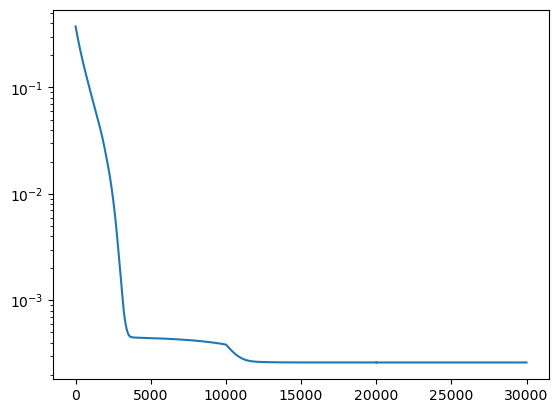

In [120]:
plt.plot(losses)
plt.yscale("log")

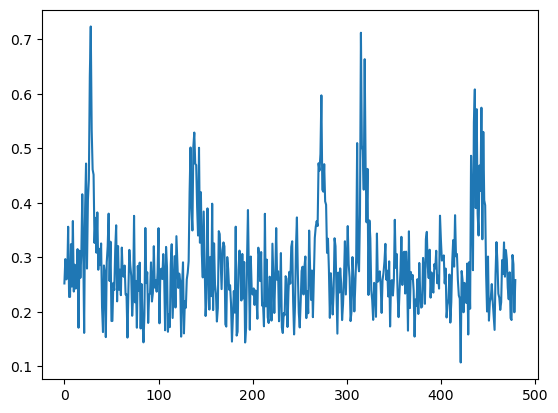

In [119]:
x_test_tensor = torch.tensor(attackPfData, dtype=torch.float32, device=device)
x_test_pre= model(x_test_tensor)
bias= torch.abs(x_test_tensor-x_test_pre).sum(dim= 1)
plt.plot(bias.detach().cpu().numpy())